# Work-flow

Example with the 'sample data set'

__Example with PAN image, single channel!__


## Step 0
Importing the libraries and the functions

In [1]:
from __future__ import print_function

import json
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
plt.ion()
from shapely.geometry import Point, Polygon
import shapely.wkt

import geopandas as gpd
from rasterio.plot import show
import sys
import geojson
from descartes import PolygonPatch


from skimage.transform import resize
import skimage.draw
from skimage.io import imsave, imread


from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

from sklearn.model_selection import train_test_split
plt.rcParams['figure.figsize'] = (8, 8)

# Prettier plotting with seaborn
import seaborn as sns; 
sns.set(font_scale=1.5)
sns.set_style("white")

Using TensorFlow backend.


## Step 1
Path directory images and mask

In [2]:

def path_from_AOI_id(AOI_id):

    if AOI_id=='AOI_5':
        Path_AOI_id='AOI_5_Khartoum_Train'
    if AOI_id=='AOI_4':
        Path_AOI_id='AOI_4_Shanghai_Train'
    if AOI_id=='AOI_3':
        Path_AOI_id='AOI_3_Paris_Train'
    if AOI_id=='AOI_2':
        Path_AOI_id='AOI_2_Vegas_Train'
   
    return Path_AOI_id

def name_file(image_path):
    #Select the tiff file inside a directory'
    images=[]
    for file in os.listdir(image_path):
        if file.endswith(".tif"):
            images.append(file)
            
    return images

def name_file_geojson(image_path):
    #Select the geojson file inside a directory'
    images=[]
    for file in os.listdir(image_path):
        if file.endswith(".geojson"):
            images.append(file)
            
    return images

def get_ch_rows_columns(image_path):
    # get the number of channela, rows and columns
    # of the images that are inside the im directory (image_path)
    # it doesn't work with the mask()
    # it takes the first image as example
    images=name_file(image_path)
    if len(images)>0:
        name=os.path.join(image_path, images[1])
    
        with rio.open(name, "r") as src2:
            array = src2.read()
        return array.shape
    else:
        print('no image in the directory')

def get_image_id(image_name):
    #for example, image_name=PAN_AOI_5_Khartoum_img9 takes just AOI_5_Khartoum_img9
    # it is used to get the masks inside the summary table
    x=image_name.split('AOI')
    image_id='AOI'+ x[-1]
    image_id=image_id.split('.tif')[0]
    return image_id 


#open the summary of the polygons observed in each city
def summary_poly_AOI_id(AOI_id):
    image_path=get_image_path(AOI_id,'Sum')
    os.listdir(image_path) 
    for file in os.listdir(image_path):
        if file.endswith(".csv"):
            name_file= image_path+file
            df=pd.read_csv(name_file)     
    return df

## image path


#MUL_path    = path_from_AOI_id(AOI_id)+'/MUL/'
#PAN_path    = path_from_AOI_id(AOI_id)+'/PAN/'
#MUL_ps_path = path_from_AOI_id(AOI_id)+'/MUL-PanSharpen/'
#RGB_path    = path_from_AOI_id(AOI_id)+'/RGB-PanSharpen/'
#mask_path   = path_from_AOI_id(AOI_id)+'/geojson/buildings/'


def get_image_path(AOI_id,fmt):
    if fmt=='MUL':
        image_path     = path_from_AOI_id(AOI_id)+'/MUL/'
    if fmt=='PAN':
        image_path     = path_from_AOI_id(AOI_id)+'/PAN/'
    if fmt=='PAN_sh':
        image_path    = path_from_AOI_id(AOI_id)+'/MUL-PanSharpen/'
    if fmt=='RGB':
        image_path     = path_from_AOI_id(AOI_id)+'/RGB-PanSharpen/'
    if fmt=='mask':
        image_path     = path_from_AOI_id(AOI_id)+'/geojson/buildings/'
    if fmt=='Sum':
        image_path     = path_from_AOI_id(AOI_id)+'/summaryData/'
    return image_path


def loading_data():
    X= np.load('data/X.npy')
    Y= np.load('data/Y.npy')
    Y_order= np.load('data/Y_order.npy')  
    return X, Y, Y_order


def loading_test_data():
    Y_test = np.load('data/y_test.npy')
    indices_Y= np.load('data/indices_test.npy')
    return Y_test, indices_Y


def loading_train_data():
    X_train = np.load('data/X_train.npy')
    Y_train = np.load('data/y_train.npy')
    return X_train, Y_train

AOI_id='AOI_2'
fmt='PAN'
image_path=get_image_path(AOI_id,fmt)
get_ch_rows_columns(image_path)



(1, 650, 650)

In [3]:
#spacenet_sample/AOI_2_Vegas_Train/PAN/PAN_AOI_2_Vegas_img5184.tif


## Step 2.1
Saving the images in a np.array --> X_train (n_images, nrows,ncolumn) 

In [4]:

def create_x_train_data(image_path):
    
    ## for images having one channel
    ## PAN that has 1 channel
    ## 
    images = name_file(image_path)
    total = len(images)
    ch,rows,cols=get_ch_rows_columns(image_path)

    imgs = np.ndarray((total, rows, cols), dtype=np.uint8)
    i = 0
    print('-'*30)
    print('Creating training images...')
    print('-'*30)
    for image_name in images:
        # 1. reading the image with imread
        # 2. transforming in a np.array with np.array([])
        # 3. saving the array in the i position of the imgs(Nimages x rows x columns)
        img = imread(os.path.join(image_path, image_name), as_gray=True)
        img = np.array([img])
        imgs[i] = img
        if i % 100 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')
    #np.save('imgs_train.npy', imgs)
    #np.save('imgs_mask_train.npy', imgs_mask)
    #print('Saving to .npy files done.')
    return imgs

def create_x_train_data_RGB(image_path):
    
    ## for images having more than one channel
    ## RGB that has 3 channel
    ## 
    images = name_file(image_path)
    total = len(images)
    ch,rows,cols=get_ch_rows_columns(image_path)

    imgs_RGB = np.ndarray((total, rows, cols,ch), dtype=np.uint8)
    i = 0
    print('-'*30)
    print('Creating training images...')
    print('-'*30)
    for image_name in images:
        # 1. reading the image with imread
        # 2. transforming in a np.array with np.array([])
        # 3. saving the array in the i position of the imgs(Nimages x rows x columns)
        img = imread(os.path.join(image_path, image_name))
        
        img = np.array([img])
        imgs_RGB[i] = img
        if i % 100 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')
    #np.save('imgs_train.npy', imgs)
    #np.save('imgs_mask_train.npy', imgs_mask)
    #print('Saving to .npy files done.')
    return imgs_RGB

def create_x_train_data_MUL8(image_path):
    
    ## for images having more than one channel
    ## Mul with 8 channels 
    ## 
    images = name_file(image_path)
    total = len(images)
    ch,rows,cols=get_ch_rows_columns(image_path)

    imgs_MUL8 = np.ndarray((total, rows, cols,ch), dtype=np.uint8)
    i = 0
    print('-'*30)
    print('Creating training images...')
    print('-'*30)
    for image_name in images:
        # 1. reading the image with imread
        # 2. transforming in a np.array with np.array([])
        # 3. saving the array in the i position of the imgs(Nimages x rows x columns)
        img = imread(os.path.join(image_path, image_name))
        
        img = np.array([img])
        imgs_RGB[i] = img
        if i % 100 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')
    #np.save('imgs_train.npy', imgs)
    #np.save('imgs_mask_train.npy', imgs_mask)
    #print('Saving to .npy files done.')
    return imgs_MUL8




## Step 2.2
Saving the corresponding masks in a np.array --> Ytrain (n_images, nrows,rcolumn).
It takes the polygon from the  csv file in the SummaryData

In [5]:
AOI_id='AOI_2'
fmt='Sum'

image_id='AOI_4_Shanghai_img3344'
df=summary_poly_AOI_id(AOI_id)
    
def create_mask_im(df,image_id):
    #for each image_id create a mask based on the polygons
    # described in the summary table
    im_mask = np.zeros((650, 650))
    
    for idx, row in df[df.ImageId == image_id].iterrows():
        shape_obj = shapely.wkt.loads(row.PolygonWKT_Pix)
        if shape_obj.exterior is not None:
            coords = list(shape_obj.exterior.coords)
            x = [round(float(pp[0])) for pp in coords]
            y = [round(float(pp[1])) for pp in coords]
            yy, xx = skimage.draw.polygon(y, x, (650, 650))
            im_mask[yy, xx] = 1

            interiors = shape_obj.interiors
            for interior in interiors:
                coords = list(interior.coords)
                x = [round(float(pp[0])) for pp in coords]
                y = [round(float(pp[1])) for pp in coords]
                yy, xx = skimage.draw.polygon(y, x, (650, 650))
                im_mask[yy, xx] = 0
    im_mask = (im_mask > 0.5).astype(np.uint8)
    return im_mask


def create_y_train_data(image_path,df):
    # takes the image_id of the tiff images and 
    # check if they can be found in df
    
    images = name_file(image_path)
    total = len(images)

    imgs_mask = np.ndarray((total, 650, 650), dtype=np.uint8)
    imgs_order= [None] * total
    i = 0
    print('-'*30)
    print('Creating y training images...')
    print('-'*30)
    for image_name in images:
         # 1. control if the image_id in image_name is contained in df
         # 2. store the mask in the imgs.mask (in the same order of the images)  
        image_id= get_image_id(image_name)
        if len(df[df.ImageId == image_id]) == 0:
            print("ImageId not found on summaryData: {}".format(image_id))
        else:
            img = create_mask_im(df,image_id)
            imgs_mask[i] = img
            imgs_order[i] = image_id
            
        if i % 100 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')
    return imgs_mask, imgs_order



def splitting_data_test_train():
    X,y = loading_data()
    X_train, X_test, y_train, y_test, indices_train,indices_test = train_test_split(
    X, y, Y_order, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test, indices_train,indices_test 


    

In [6]:
AOI_id='AOI_2'
fmt='PAN'
image_path=get_image_path(AOI_id,fmt)

df=summary_poly_AOI_id(AOI_id)
X=create_x_train_data(image_path)
Y, Y_order=create_y_train_data(image_path,df)

#saving the file
data_direct='data/'
np.save(os.path.join(data_direct,'X.npy'),X)
np.save(os.path.join(data_direct,'Y.npy'),Y)
np.save(os.path.join(data_direct,'Y_order.npy'),Y_order)

print('Saving to .npy files done.')

------------------------------
Creating training images...
------------------------------
Done: 0/10 images
Loading done.
------------------------------
Creating y training images...
------------------------------
Done: 0/10 images
Loading done.
Saving to .npy files done.


In [7]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(X, Y,Y_order, test_size=0.33, random_state=42)


In [8]:
np.save(os.path.join(data_direct,'X_train.npy'), X_train)
np.save(os.path.join(data_direct,'Y_train.npy'), y_train)
np.save(os.path.join(data_direct,'y_test.npy'),  y_test)
np.save(os.path.join(data_direct,'X_test.npy'),  X_test)
np.save(os.path.join(data_direct,'indices_test.npy'),  indices_test)
np.save(os.path.join(data_direct,'indices_train.npy'),  indices_train)

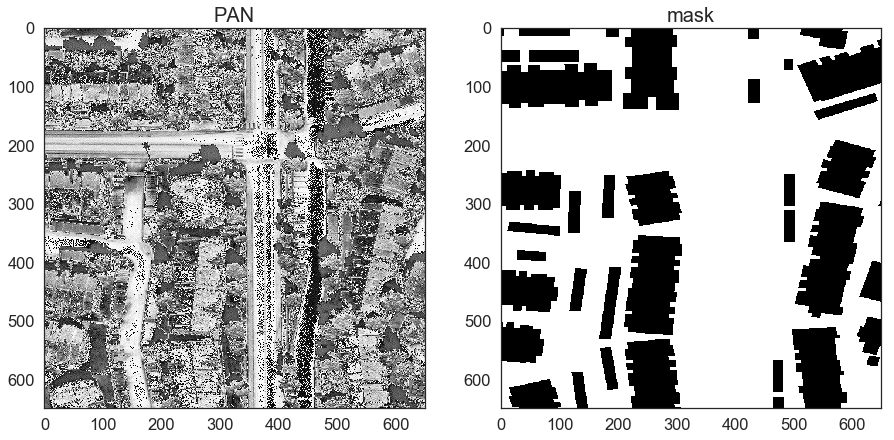

In [9]:
n_i=9
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15,15))
ax1.imshow(X[n_i],cmap='Greys') 
ax1.set_title("PAN", 
             fontsize=20);
ax2.imshow(Y[n_i],cmap='Greys')
ax2.set_title("mask", 
             fontsize=20);



The images and the polygons are saved in np.arrays (X and Y).
When plotted they are very noisy in comparison with the original images as it is shown below: 

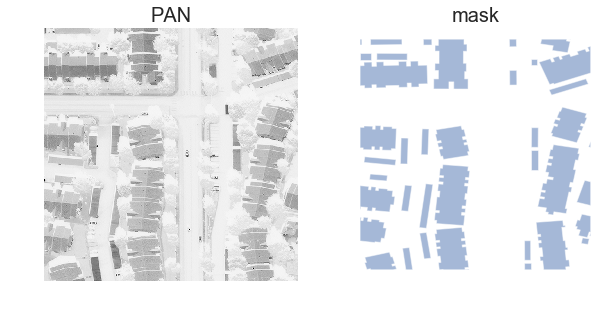

In [10]:


images = name_file(image_path)
address = image_path+images[n_i]


level=1
with rio.open(address, "r") as src2:
    PAN=src2.read(level,masked=True)
    spatial_extent = rio.plot.plotting_extent(src2)

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (10,10))

ax1.imshow(PAN, 
           cmap='Greys')

ax1.set_title('PAN', 
             fontsize=20);
ax1.set_axis_off()

## mask
fmt='mask'
image_path2=get_image_path(AOI_id,fmt)
#images2 = name_file_geojson(image_path2)
imm=images[n_i].replace('.tif','').replace('PAN_','')
images2='buildings_'+imm+'.geojson'
#search the same file with.geojson 


address2 = image_path2+images2


json_data = gpd.read_file(address2)

json_data.plot(ax=ax2,
             alpha=0.5)
ax2.set_title("mask", 
             fontsize=20);
ax2.set_axis_off()
#spatial_extent = plotting_extent(lidar_chm)






# Step 3
- Pre processing the images: resizing, filtering, normalizing
- Merging the input data from different image types (MUL+RGB+PAN+PAN_sharp) _(or training the model separately for each type of this file and then averaging the results?_
- Repeating for each type of image type
- Split the data set in a training and a testing part

In [11]:
def preprocess_ris(imgs,img_cols,img_rows):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

def normalizing_imgs(imgs):
    imgs_n=imgs/255
    return imgs_n.astype('float32')

def normalizing_mean_imgs(imgs):
    #--------------------------
    #
    ## normalize the images using the mean values
    ## it computes the mean values directly from the X object
    ## for RGB images the mean value is computed for each channel
    ## N.B the mean values are affected by the number of considered images
    #
    #----------------------
    if np.size(imgs.shape)>3:
        norm_R=np.uint8(imgs[:,:,:,0].mean())
        norm_G=np.uint8(imgs[:,:,:,1].mean())
        norm_B=np.uint8(imgs[:,:,:,2].mean())
        imgs[:,:,:,0]-=norm_R
        imgs[:,:,:,1]-=norm_G
        imgs[:,:,:,2]-=norm_B
    else:
        norm=np.uint8(imgs.mean())
        imgs-=norm
    return imgs               


def normalizing_RGB_imgs(imgs,image_path):
    #--------------------------
    #
    ## normalize the images using the mean values
    ## that are computed previously
    #
    #----------------------
    norm_r,norm_g,norm_b = getting_mean_from_RGBimages(image_path)
    imgs[:,:,:,0]-=norm_r
    imgs[:,:,:,1]-=norm_g
    imgs[:,:,:,2]-=norm_b
    return imgs

def normalizing_1ch_imgs(imgs,image_path):
    #--------------------------
    #
    ## normalize the images using the mean values
    ## that are computed previously
    #
    #----------------------
    norm =getting_mean_from_images(image_path)
    imgs-=norm
    return imgs

def getting_mean_from_images(image_path):
    
    ## for images having one channel
    ## PAN that has 1 channel
    ## 
    images = name_file(image_path)
    total = len(images)

    mean_imag = 0
    i = 0
    print('-'*30)
    print('evaluating mean images...')
    print('-'*30)
    for image_name in images:
        img = imread(os.path.join(image_path, image_name), as_gray=True)
        r=img.mean()
        mean_imag+=r
        if i % 100 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    mean_imag=np.uint8(mean_imag/total)

    
def getting_mean_from_RGBimages(image_path):
    
    ## for RGB images having more than one channel
    images = name_file(image_path)
    total = len(images)
   
    mean_imagR = 0
    mean_imagG = 0
    mean_imagB = 0
    i = 0
    print('-'*30)
    print('evaluating mean images...')
    print('-'*30)
    for image_name in images:
        img = imread(os.path.join(image_path, image_name))
        r=img[:,:,0].mean()
        g=img[:,:,1].mean()
        b=img[:,:,2].mean()
        mean_imagR += r
        mean_imagG += g
        mean_imagB += b

        if i % 100 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    mean_imagR =  np.uint8(mean_imagR/total)
    mean_imagG =  np.uint8(mean_imagG/total)
    mean_imagB =  np.uint8(mean_imagB/total)
    return mean_imagR, mean_imagG, mean_imagB
    

# Step 4
Model definition: example taken from https://github.com/jocicmarko/ultrasound-nerve-segmentation

In [47]:
smooth=1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def get_unet():
    img_rows=96
    img_cols=96
    inputs = Input((img_rows, img_cols, 1))
    # imputs = Input((img_rows, img_cols, 3)) for RGB images
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model


# Step 5
Train and predict

In [50]:


def train_mod():
    img_rows=96
    img_cols=96
  
    Xtrain,Ytrain = loading_train_data()
    Xtrain=preprocess_ris(Xtrain,img_cols,img_rows)
    Ytrain=preprocess_ris(Ytrain,img_cols,img_rows)
    Xtrain= normalizing_imgs(Xtrain)
    Ytrain= normalizing_imgs(Ytrain)
   
    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    
    # (default values for the arguments of model.fit) 
    # fit(x=None, y=None, batch_size=None, epochs=1, 
    #    verbose=1, callbacks=None, validation_split=0.0, 
    #    validation_data=None, shuffle=True, class_weight=None, 
    #    sample_weight=None, initial_epoch=0, steps_per_epoch=None, 
    #    validation_steps=None, validation_freq=1)
    
    model.fit(Xtrain, Ytrain, batch_size=2, epochs=20, verbose=2, shuffle=True,
              validation_split=0.2,
              callbacks=[model_checkpoint])
    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('weights.h5')

    return model

def predict_mod():
    img_rows=96
    img_cols=96
  
    Ytest,indices_test = loading_test_data()
    Ytest=preprocess_ris(Ytest,img_cols,img_rows)
    Ytest= normalizing_imgs(Ytest)

    
    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(Ytest, verbose=2)
    np.save('data/imgs_mask_test.npy', imgs_mask_test)

    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)
    pred_dir = 'data'
    
    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)
    for image, image_id in zip(imgs_mask_test, indices_test):
        image = (image[:, :, 0] * 255.).astype(np.uint8)
        imsave(os.path.join(pred_dir, str(image_id) + '_pred.png'), image)
    return np.save(os.path.join(pred_dir,'imgs_mask_test.npy'), imgs_mask_test) 

In [51]:
model=train_mod()


------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
Train on 4 samples, validate on 2 samples
Epoch 1/20
 - 5s - loss: -5.4662e-04 - dice_coef: 5.4662e-04 - val_loss: -3.4364e-04 - val_dice_coef: 3.4364e-04
Epoch 2/20
 - 1s - loss: -5.4663e-04 - dice_coef: 5.4663e-04 - val_loss: -3.4368e-04 - val_dice_coef: 3.4368e-04
Epoch 3/20
 - 1s - loss: -5.4685e-04 - dice_coef: 5.4685e-04 - val_loss: -3.4373e-04 - val_dice_coef: 3.4373e-04
Epoch 4/20
 - 1s - loss: -5.4692e-04 - dice_coef: 5.4692e-04 - val_loss: -3.4379e-04 - val_dice_coef: 3.4379e-04
Epoch 5/20
 - 1s - loss: -5.4686e-04 - dice_coef: 5.4686e-04 - val_loss: -3.4385e-04 - val_dice_coef: 3.4385e-04
Epoch 6/20
 - 1s - loss: -5.4693e-04 - dice_coef: 5.4693e-04 - val_loss: -3.4391e-04 - val_dice_coef: 3.4391e-04
Epoch 7/20
 - 1s - loss: -5.4701e-04 - dice_coef: 5.4701e-04 - val_loss: -3.4397e-04 - val_dice_coef: 3.439

In [43]:
predict_mod()

------------------------------
Predicting masks on test data...
------------------------------
------------------------------
Saving predicted masks to files...
------------------------------


/Users/sabrina/.pyenv/versions/3.6.5/envs/sab365/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/AOI_2_Vegas_img2636_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/sabrina/.pyenv/versions/3.6.5/envs/sab365/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/AOI_2_Vegas_img5184_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/sabrina/.pyenv/versions/3.6.5/envs/sab365/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/AOI_2_Vegas_img802_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/sabrina/.pyenv/versions/3.6.5/envs/sab365/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/AOI_2_Vegas_img246_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


# Step 6
Evaluate the result


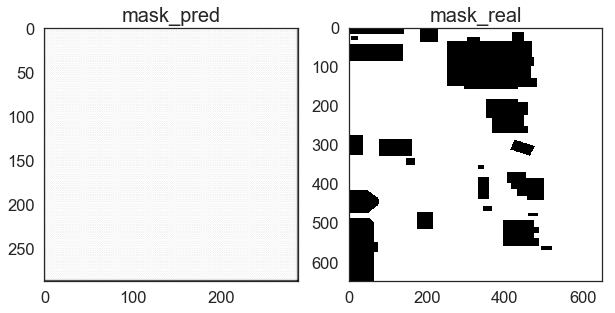

In [44]:
mask_pred = 'data/imgs_mask_test.npy'
mask_real = 'data/y_test.npy'

level=1
mask_pred1 = np.load(mask_pred)
mask_real1 = np.load(mask_real)


n_i=1

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (10,10))
ax1.imshow(mask_pred1[n_i,:,:,0],cmap='Greys')
ax1.set_title("mask_pred", 
             fontsize=20);

ax2.imshow(mask_real1[n_i],cmap='Greys')
ax2.set_title("mask_real", 
             fontsize=20);

